In [1]:
import torch 
import torch.nn as nn

In [2]:
#example
#config for gpt-2 small model

GPT_CONFIG_124M={
    "vocab_size":50257,
    "context_length":1024,
    "emb_dim":768,
    "n_heads":12,
    "n_layers":12,
    "drop_rate":0.1,
    "qkv_bias":False
}

In [3]:
#dummy gpt model class

#step 1:use a placeholder for transformer block

#step 2:use a placeholder for LayerNorm
import torch 
import torch.nn as nn
class DummyGPTModel(nn.Module):

    def __init__(self,cfg):#cgf-configuration of gpt-2 model
        super().__init__()
        self.tok_emb=nn.Embedding(cfg["vocab_size"],cfg["emb_dim"])
        self.pos_emb=nn.Embedding(cfg["context_length"],cfg["emb_dim"])
        self.drop_emb=nn.Dropout(cfg["drop_rate"])

        #use a placeholder for transformer block
        self.trf_blocks=nn.Sequential(
            *[DummyTransformerBlock(cfg) for _ in range(cfg["n_layers"])]
        )

        #use a placeholder for LayerNorm
        self.final_norm=DummyLayerNorm(cfg["emb_dim"])
        self.out_head=nn.Linear(
            cfg["emb_dim"],cfg["vocab_size"],bias=False
        )

    def forward(self,in_idx):
        batch_size,seq_len=in_idx.shape#batch_size-no of inputs,seq_len=length of no of tokens of each input in batch
        tok_embeds=self.tok_emb(in_idx)#token embeddings for input token ids each token id will have 768 dimensional token embedding
        pos_embeds=self.pos_emb(torch.arange(seq_len,device=in_idx.device))#here arange is used for each input sequence there will be n number of tokens ,it is creating positional embedding vectors for n number of tokens.positional embedding created for one input sequence is used for all the other input sequences
        x=tok_embeds+pos_embeds
        #input token embeddings
        x=self.drop_emb(x)
        #dropout layer
        x=self.trf_blocks(x)
        #transformer block-implementing layernorm,multi-head attention,dropout layers
        x=self.final_norm(x)
        #final norm layer: shape until this step-(num_of_tokens_in_input_seq x number-of-embedding-dimension)
        logits=self.out_head(x)
        return logits#logitsdimension-(no_of_tokens_input_seq x vocab_size ) each row represents probability for each of the 50527 words to occur in that place

class DummyTransformerBlock(nn.Module):
    def __init__(self,cfg):
        super().__init__()

    
    def forward(self,x):
        return x


class DummyLayerNorm(nn.Module):
    def __init__(self,cfg):
        super().__init__()

    
    def forward(self,x):
        return x

In [4]:
#Complete Transformer Block

class LayerNorm(nn.Module):

    def __init__(self,emb_dim):
        super().__init__()
        self.eps=1e-5
        self.scale=nn.Parameter(torch.ones(emb_dim))
        self.shift=nn.Parameter(torch.zeros(emb_dim))

    def forward(self,x):
        mean=x.mean(dim=-1,keepdim=True)
        var=x.var(dim=-1,keepdim=True)
        norm_x=(x-mean)/torch.sqrt(var+self.eps)
        return self.scale*norm_x +self.shift
    
#GELU Activation class
class GELU(nn.Module):
    def __init__(self):
        super().__init__()
    
    def forward(self,x):
        return 0.5 * x *(1+torch.tanh(
            torch.sqrt(torch.tensor(2.0/torch.pi))*
            (x+0.044715*torch.pow(x,3))
        ) 

        )

# FeedForward Neural Network used inside Transformer blocks
class FeedForward(nn.Module):
    def __init__(self, cfg):
        super().__init__()

        emb = cfg["emb_dim"]
        hidden = 4 * emb   # Expanded dimension

        self.layers = nn.Sequential(
            # -------- EXPANSION --------
            # Increase embedding size from emb → 4*emb
            # Gives the model more capacity and richer feature space
            nn.Linear(emb, hidden),

            # -------- ACTIVATION --------
            # GELU adds non-linearity and helps the network learn complex patterns
            GELU(),

            # -------- CONTRACTION --------
            # Bring dimension back from 4*emb → emb
            # Keeps output compatible with the transformer's embedding size
            nn.Linear(hidden, emb)
        )

    def forward(self, x):
        return self.layers(x)


In [82]:
#improving multi head attention forward method by processing multiple heads sequentially
#here instaed of making multiple weight matrices for key,value and query we take one large matrix (for eg: if there are 2 heads with 2 separate weight matrix ,the output will be 2 different matrixes with dimension of (3x2) then add it along columns will result in (3x4) matrix 
# but here we are taking one large weight matrix with dimension of (3x4) and find query,key,value matrices and split them with num_heads(2) ,result in two 3x2 matrices)
import torch.nn as nn
class MultiHeadAttention(nn.Module):
    def __init__(self,d_in,d_out,context_length,num_heads,dropout,qkv_bias=False):
        super().__init__()
        assert (d_out%num_heads==0),"d_out must be divisible by num_heads"

        self.d_out=d_out
        self.num_heads=num_heads
        self.head_dim = d_out//num_heads #finding dimension of each head
        self.W_key=nn.Linear(d_in,d_out,bias=qkv_bias)
        self.W_query=nn.Linear(d_in,d_out,bias=qkv_bias)
        self.W_value=nn.Linear(d_in,d_out,bias=qkv_bias)
        self.out_proj=nn.Linear(d_out,d_out)
        self.dropout=nn.Dropout(dropout)
        self.register_buffer("mask",torch.triu(torch.ones(context_length,context_length),diagonal=1))

    def forward(self,x):
        b,num_tokens,d_in=x.shape

        #shape for keys,queries,values matrix=(b,num_tokens,d_out)
        keys=self.W_key(x)
        queries=self.W_query(x)
        values=self.W_value(x)

        #split the larger matrices(keys,queries,values) according to num of heads
        #unroll last dimension to split the matrices according to no of heads:(b,num_tokens,d_out)->(b,num_tokens,num_heads,head_dim)
        keys=keys.view(b,num_tokens,self.num_heads,self.head_dim)
        queries=queries.view(b,num_tokens,self.num_heads,self.head_dim) 
        values=values.view(b,num_tokens,self.num_heads,self.head_dim) 

        #grouping according to num of heads by transposing
        #(b,num_tokens,num_heads,head_dim)->(b,num_heads,num_tokens,head_dim)
        keys=keys.transpose(1,2)
        queries=queries.transpose(1,2)
        values=values.transpose(1,2)

        #computing attention scores
        attn_scores=queries@keys.transpose(2,3)
        #here, each row i in each head represents the attention score of ith token with respect to all tokens in that head

        #implementing mask for upper diagonal
        mask_bool=self.mask.bool()[:num_tokens,:num_tokens]

        #masking the attention scores
        attn_scores.masked_fill_(mask_bool,-torch.inf)

        attn_weights=torch.softmax(attn_scores/keys.shape[-1]**0.5,dim=-1)#keys.shape[1] refers to head_dim
        attn_weights=self.dropout(attn_weights)

        #context vector: shape->(b,num_tokens,num_heads,head_dim)
        context_vec=(attn_weights@values).transpose(1,2)

        #combine heads,where d_out=num_heads*head_dim
        context_vec=context_vec.contiguous().view(b,num_tokens,self.d_out)#values are stored sometimes non-contiguously in memory.if dimesnion changed on non-contiguously,it will lead to error.This method(contiguous) makes a new tensor with the same values but stored in a clean, contiguous memory block.
        context_vec=self.out_proj(context_vec)#optional projection layer

        return context_vec






In [83]:
#Transformer Block

class TransformerBlock(nn.Module):
    def __init__(self,cfg):
        super().__init__()
        #Multihead attention instance for converting embedding vectors into context vectors
        self.att=MultiHeadAttention(
            d_in=cfg["emb_dim"],
            d_out=cfg["emb_dim"],
            context_length=cfg["context_length"],
            num_heads=cfg["n_heads"],
            dropout=cfg["drop_rate"],
            qkv_bias=cfg["qkv_bias"]
        )
        #FeedForward Neural Network instance
        self.ff=FeedForward(cfg)
        #LayerNormalization instance 1 
        self.norm1=LayerNorm(cfg["emb_dim"])
        #LayerNormalization instance 2
        self.norm2=LayerNorm(cfg["emb_dim"])
        #Dropout layer
        self.drop_shortcut=nn.Dropout(cfg["drop_rate"])

    def forward(self,x):
        #input x is preserved for adding after output from first part of transformer
        shortcut=x
        #################Part 1 of transformer################
        #First input passing through Layer normalization layer 1
        x=self.norm1(x)
        #output from LayerNorm layer 1 passing through multi head attention
        x=self.att(x) # shape[batch_size,num_tokens,emb_size]
        #dropout layer
        x=self.drop_shortcut(x)
        #output is added with input(initial/original input)
        x=x+shortcut

        #################Part 2 of transformer################
        #input x(output from 1st part of transformer) is preserved for adding after output from 2nd part of transformer
        shortcut=x
        # input from 1st part of transformer passing through Layer normalization layer 1
        x=self.norm2(x)
        #ouput from LayerNorm 2nd layer is passed through feed forward neural network
        x=self.ff(x)
        #output from FeedForward NN is passed through dropout layer
        x=self.drop_shortcut(x)
        #ouput from above dropout layer is added with shortcut input(output of 1st part of transformer)
        x=x+shortcut

        return x


In [84]:


torch.manual_seed(123)
x=torch.rand(2,4,768)
block=TransformerBlock(GPT_CONFIG_124M)
output=block(x)
print("Input shape:",x.shape)
print("Output shape:",output.shape)
#same shape for input and output
#remember transformer block only doing operstions with layer normaliation,multi head attention ,dropout ,shortcut connections,feedforward neural network while keeping the dimension of input same as through the output
#but the output vectors contains a rich information about each token and  how its related with other words

Input shape: torch.Size([2, 4, 768])
Output shape: torch.Size([2, 4, 768])


In [8]:
#Complete GPT model class - 124M parameters

import torch 
import torch.nn as nn
class GPTModel(nn.Module):

    def __init__(self,cfg):#cgf-configuration of gpt-2 model
        super().__init__()
        self.tok_emb=nn.Embedding(cfg["vocab_size"],cfg["emb_dim"])
        self.pos_emb=nn.Embedding(cfg["context_length"],cfg["emb_dim"])
        self.drop_emb=nn.Dropout(cfg["drop_rate"])

        #use a placeholder for transformer block
        self.trf_blocks=nn.Sequential(
            *[TransformerBlock(cfg) for _ in range(cfg["n_layers"])]
        )

        #use a placeholder for LayerNorm
        self.final_norm=LayerNorm(cfg["emb_dim"])
        self.out_head=nn.Linear(
            cfg["emb_dim"],cfg["vocab_size"],bias=False
        )

    def forward(self,in_idx):
        batch_size,seq_len=in_idx.shape#batch_size-no of inputs,seq_len=length of no of tokens of each input in batch
        tok_embeds=self.tok_emb(in_idx)#token embeddings for input token ids each token id will have 768 dimensional token embedding
        pos_embeds=self.pos_emb(torch.arange(seq_len,device=in_idx.device))#here arange is used for each input sequence there will be n number of tokens ,it is creating positional embedding vectors for n number of tokens.positional embedding created for one input sequence is used for all the other input sequences
        x=tok_embeds+pos_embeds
        #input token embeddings
        x=self.drop_emb(x)
        #dropout layer
        x=self.trf_blocks(x)
        #transformer block-implementing layernorm,multi-head attention,dropout layers
        x=self.final_norm(x)
        #final norm layer: shape until this step-(num_of_tokens_in_input_seq x number-of-embedding-dimension)
        logits=self.out_head(x)
        return logits#logitsdimension-(no_of_tokens_input_seq x vocab_size ) each row represents probability for each of the 50527 words to occur in that place as next token to current token


In [9]:
torch.manual_seed(123)
model=GPTModel(GPT_CONFIG_124M)
batch=torch.tensor([[6109,3626,6100,345],
                    [6109,1110,6622,257]])
#2 input sequence with 4 token ids each
out=model(batch)
print("Input batch:\n",batch)
print("Output shape:",out.shape)
#here output shape is 3d vector for 2 inputs with each having 4 tokens and each token having 50257 dimensions(it contains probability of each of 50257 words to oocur as next word) 
print(out)

Input batch:
 tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])
Output shape: torch.Size([2, 4, 50257])
tensor([[[ 0.3612,  0.4223, -0.0709,  ...,  0.3479,  0.4655, -0.2833],
         [-0.1520, -0.5036, -0.8496,  ...,  0.0875,  0.5710, -0.3421],
         [ 0.7495,  0.0505,  0.0259,  ...,  0.0527, -0.4995, -0.1761],
         [-0.9089,  0.4484, -0.1124,  ...,  0.7924,  0.4422, -0.0015]],

        [[-0.2562,  0.0899,  0.0338,  ...,  0.2659,  0.4448, -0.6800],
         [ 0.1318,  0.4321, -0.1967,  ...,  0.8461,  0.2094,  0.1714],
         [ 1.0333,  1.0043, -0.2194,  ...,  0.6317,  0.3790, -0.2896],
         [-0.1300,  0.3927,  0.3873,  ...,  1.2650, -0.1869, -0.0020]]],
       grad_fn=<UnsafeViewBackward0>)


In [10]:
#calculating total no of parameters
total_params=sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {total_params:,}")
#here parameters is 163M which is greater than 124M because in initial GPT-2 Architecture , parameters used in token embeddings are reused in final output layer but here parameters are not reused that why 163M parameters
#proof is below

Total number of parameters: 163,009,536


In [11]:
print("Token embedding layer shape:",model.tok_emb.weight.shape)
print("Output layer shape:",model.out_head.weight.shape)

Token embedding layer shape: torch.Size([50257, 768])
Output layer shape: torch.Size([50257, 768])


In [12]:
#so remove the parameters count  reused in final output layer
total_params_gpt2=total_params-sum(p.numel() for p in model.out_head.parameters())
print(f"Number of trainable parameters considering weight tying: {total_params_gpt2}")
#now it is 124M parameters
#but using separete weights for token embedding layer and output layer is good for prediction . it is used in LLMs

Number of trainable parameters considering weight tying: 124412160


In [13]:
#space taken by the model
total_size_bytes=total_params*4
total_size_mb=total_size_bytes/(1024*1024)
print(f"Total size of the model: {total_size_mb:.2f} MB")

Total size of the model: 621.83 MB


In [14]:
#generating text from output token

def generate_text_simple(model,idx,max_new_tokens,context_size):
    #idx is inputs(batch size,num_of tokens)
    #model- GPT-2 Model
    #max_new_tokens-no of tokens to be predicted

    for _ in range(max_new_tokens):
        #eg: if llm supports only 5 tokens, and the given context_size is 10
        #then only last 5 tokens are used as context
        idx_cond=idx[:,-context_size:]
        #getting token ids in an input sequence only until context size limit

        with torch.no_grad():
            logits=model(idx_cond)##shape-(no_of_batches,no_of_tokens_in_each_input,vocab_size)

        logits=logits[:,-1,:]#getting last row from each inputs of a btach

        #applying softmax for finding probabilties. dim=-1 because values are summed up along column for each row 
        probabs=torch.softmax(logits,dim=-1)

        #finding highest probabilty value index for each row 
        idx_next=torch.argmax(probabs,dim=-1,keepdim=True)


        idx = torch.cat((idx,idx_next),dim=1)#(batch,n_tokens+1)

    return idx


In [15]:
import tiktoken
tokenizer=tiktoken.get_encoding("gpt2")

In [16]:
start_context="Hello, I am"
encoded=tokenizer.encode(start_context)
print("encoded: ",encoded)
encoded_tensor=torch.tensor(encoded).unsqueeze(0)
#shape changed in shape of (batch,num_of_tokens)
print("encoded tensor shape: ", encoded_tensor.shape)

encoded:  [15496, 11, 314, 716]
encoded tensor shape:  torch.Size([1, 4])


In [17]:
model.eval()
out=generate_text_simple(
    model=model,
    idx=encoded_tensor,
    max_new_tokens=6,
    context_size=GPT_CONFIG_124M["context_length"]
)

print("Output:",out)
#here inputs are 4 tokens but output is 10 tokens
#started withed 4 tokens,it add 5th token and give 5 tokens as input and find 6th token like this iteratively do until max_new_tokens limit 
print("Output length :",len(out[0]))

Output: tensor([[15496,    11,   314,   716, 27018, 24086, 47843, 30961, 29739,   554]])
Output length : 10


In [18]:
decoded_text=tokenizer.decode(out.squeeze(0).tolist())#squeeze remove the 1st dimesnion here out-(1,10)-it removed 1st dimension(batch size dimension) and converted it into single list
print(decoded_text)
#the output is random because the model is not trained all the 124M parameters should be trained

Hello, I am Featureiman Byeswick Exit In


In [19]:
#config for gpt-2 small model

GPT_CONFIG_124M={
    "vocab_size":50257,
    "context_length":256,#shorten for training simplicity
    "emb_dim":768,
    "n_heads":12,
    "n_layers":12,
    "drop_rate":0.1,
    "qkv_bias":False
}

torch.manual_seed(123)
model=GPTModel(GPT_CONFIG_124M)
model.eval() ;#disable dropout during training

In [20]:
#predefining methods to encoe and decode

def text_to_token_ids(text,tokenizer):
    encoded=tokenizer.encode(text,allowed_special={'<|endoftext|>'})
    encoded_tensor=torch.tensor(encoded).unsqueeze(0) # adding batch dimension
    return encoded_tensor

def token_ids_to_text(token_ids,tokenizer):
    flat=token_ids.squeeze(0) #remove batch dimension
    return tokenizer.decode(flat.tolist())


#example
start_context="Every Effort moves you"

tokenizer=tiktoken.get_encoding("gpt2")

token_ids=generate_text_simple(
    model=model,
    idx=text_to_token_ids(start_context,tokenizer),
    max_new_tokens=10,
    context_size=GPT_CONFIG_124M["context_length"]
)

print("Output text:\n",token_ids_to_text(token_ids,tokenizer))

Output text:
 Every Effort moves you finisheduxeHandle appropriation pigment Primordial Dying counsellingilibriumolve


In [21]:
inputs = torch.tensor([[16833, 3626, 6100],   # ["every effort moves",
                       [40,    1107, 588]])   #  "I really like"]

targets = torch.tensor([[3626, 6100, 345  ],  # [" effort moves you",
                        [1107,  588, 11311]]) #  " really like chocolate"]

In [22]:
with torch.no_grad():
    logits=model(inputs)

probabs=torch.softmax(logits,dim=-1)
print(probabs.shape) #raw output from gpt model with shape of (batch-size,no-of-tokens,vocab_size)

torch.Size([2, 3, 50257])


In [23]:
token_ids=torch.argmax(probabs,dim=-1,keepdim=True)#predicted tokens for each input sequence
print("Token IDs:\n",token_ids)

Token IDs:
 tensor([[[16657],
         [13866],
         [44376]],

        [[49906],
         [29669],
         [41751]]])


In [24]:
print(f"Actual Output(Target) for batch 1: {token_ids_to_text(targets[0],tokenizer)}")
print(f"Predicted Output for batch 1: {token_ids_to_text(token_ids[0].flatten(),tokenizer)}")

Actual Output(Target) for batch 1:  effort moves you
Predicted Output for batch 1:  Armedbage inaction


In [25]:
text_idx=0
#probabs shape(2,3,505257)- 2 input sequences with 3 tokens and each token having 50257 dimesnional vector
target_probas_1=probabs[text_idx,[0,1,2],targets[text_idx]]#here text_idx=input sequence no,[0,1,2]-no of tokens,target[text_idx]-finding probabilities in indexes of the actual output for that input sequence
#[0,[0,1,2],[[3626, 6100, 345]] target value given above
print("Text 1:",target_probas_1)

text_idx=1
target_probas_2=probabs[text_idx,[0,1,2],targets[text_idx]]
print("Text 2:",target_probas_2)


Text 1: tensor([7.4514e-05, 2.9619e-05, 1.2005e-05])
Text 2: tensor([1.0343e-05, 5.5137e-05, 5.1461e-06])


In [26]:
#computing logarithm of all token probabilities
log_probabs=torch.log(torch.cat((target_probas_1,target_probas_2)))#merged before taking log here
print(log_probabs)

tensor([ -9.5045, -10.4271, -11.3302, -11.4792,  -9.8057, -12.1773])


In [27]:
#mean- average probability for each token
avg_log_probas=torch.mean(log_probabs)
print(avg_log_probas)

#negative likelihood loss - taking negative value of mean of log of all probabilities 
neg_avg_log_probas=avg_log_probas*-1
print(neg_avg_log_probas)
#want to reduce the negative likelihood as much  as possible

tensor(-10.7873)
tensor(10.7873)


In [28]:
#another way to calculate cross-entropy loss

logits_flat=logits.flatten(0,1)#ignoring dimesnion 1 and 2(batch size,no of tokens) in (2,3,50257)->(6,50257)
targets_flat=targets.flatten()#(2,3)->(1,6)

print("Flattened logits:",logits_flat.shape)
print("Flattened targets:",targets_flat.shape)

Flattened logits: torch.Size([6, 50257])
Flattened targets: torch.Size([6])


In [29]:
#internal method to calculate cross entropy loss
loss=torch.nn.functional.cross_entropy(logits_flat,targets_flat)
print(loss)

tensor(10.7873)


In [30]:
#perplexity loss tells in which range the models seekd to predict from vocabulary
perplexity=torch.exp(loss)
print(perplexity)
#here the result 48403 tells that the model is seeking to predict a token from above 48403 tokens in a vocab size of 50257 tokens

tensor(48403.3320)


In [31]:
#Evaluating performance on real dataset
import os

file_path="../the-verdict.txt"

with open(file_path,"r",encoding="utf-8") as file:
    text_data=file.read()

In [32]:
print(text_data[:99])

I HAD always thought Jack Gisburn rather a cheap genius--though a good fellow enough--so it was no 


In [33]:
total_chars=len(text_data)

total_tokens=len(tokenizer.encode(text_data))
print("Characters: ",total_chars)
print("Tokens: ",total_tokens)

Characters:  20479
Tokens:  5145


In [34]:
#dividing data into taining and validation set
#using dataloader

from torch.utils.data import Dataset,DataLoader

#creating input-target pairs
class GPTDatasetV1(Dataset):
    def __init__(self,txt,tokenizer,max_length,stride):
        self.input_ids=[]
        self.target_ids=[]

        token_ids=tokenizer.encode(txt,allowed_special={"<|endoftext|>"})

        for i in range(0,len(token_ids)-max_length,stride):
            input_chunk=token_ids[i:i+max_length]
            target_chunk=token_ids[i+1:i+1+max_length]
            self.input_ids.append(torch.tensor(input_chunk))
            self.target_ids.append(torch.tensor(target_chunk))

    def __len__(self):
        return len(self.input_ids)
    
    def __getitem__(self,idx):
        return self.input_ids[idx],self.target_ids[idx]


def create_dataloader_v1(txt,batch_size=4,max_length=256,stride=128,shuffle=True,drop_last=True,num_workers=0):

    tokenizer=tiktoken.get_encoding("gpt2")

    dataset=GPTDatasetV1(txt,tokenizer,max_length,stride)

    dataloader=DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        drop_last=drop_last,
        num_workers=num_workers
    )

    return dataloader

In [35]:
#train/validation split
train_ratio=0.90
split_idx=int(train_ratio*len(text_data))
#splitting 90% of data for training and 105 for validation
train_data=text_data[:split_idx]
val_data=text_data[split_idx:]

torch.manual_seed(123)

#Dataloader creates input-target pairs
train_loader=create_dataloader_v1(
    train_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=True,
    shuffle=True,
    num_workers=0
)

val_loader=create_dataloader_v1(
    val_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=True,
    shuffle=True,
    num_workers=0
)

In [36]:
#Sanity check

if total_tokens*(train_ratio)<GPT_CONFIG_124M["context_length"]:
    print("Not enough tokens for training loader. try to lower the context_length.increase the training ratio")

if total_tokens*(1-train_ratio)<GPT_CONFIG_124M["context_length"]:
    print("Not enough tokens for validation loader. try to lower the context_length.decrease the training ratio")

In [37]:
print("Train Loader: ")
for x,y in train_loader:
    print(x.shape,y.shape)

print("Validation Loader: ")
for x,y in val_loader:
    print(x.shape,y.shape)

print(len(train_loader))
print(len(val_loader))

Train Loader: 
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
Validation Loader: 
torch.Size([2, 256]) torch.Size([2, 256])
9
1


In [38]:
#calculating loss

def calc_loss_batch(input_batch,target_batch,model,device):
    input_batch,target_batch=input_batch.to(device),target_batch.to(device)
    #logits - predicted value from model
    logits=model(input_batch)
    loss=torch.nn.functional.cross_entropy(logits.flatten(0,1),target_batch.flatten())
    return loss

def calc_loss_loader(data_loader,model,device,num_batches=None):
    total_loss=0
    if len(data_loader)==0:
        return float("nan")
    elif num_batches==None:
        num_batches=len(data_loader)
    else:
        num_batches=min(num_batches,len(data_loader))

    for i,(input_batch,target_batch) in enumerate(data_loader):
        if i<num_batches:
            loss=calc_loss_batch(input_batch,target_batch,model,device)
            total_loss+=loss.item()
        else:
            break
    return total_loss/num_batches


In [39]:
device=torch.device("cuda" if torch.cuda.is_available() else "cpu" )
torch.manual_seed(123)

with torch.no_grad():
    train_loss=calc_loss_loader(train_loader,model,device)
    val_loss=calc_loss_loader(val_loader,model,device)

print("Training loss: ",train_loss)
print("Validation Loss: ",val_loss)


Training loss:  10.987670474582249
Validation Loss:  10.980696678161621


In [40]:

def evaluate_model(model,train_loader,val_loader,device,eval_iter):
    model.eval()#disable dropout and gradient tracking
    with torch.no_grad():
        train_loss=calc_loss_loader(train_loader,model,device,num_batches=eval_iter)
        val_loss=calc_loss_loader(val_loader,model,device,num_batches=eval_iter)
    model.train()
    return train_loss,val_loss

def generate_and_print_sample(model,tokenizer,device,start_context):
    model.eval()
    context_size=model.pos_emb.weight.shape[0]
    encoded=text_to_token_ids(start_context,tokenizer).to(device)
    with torch.no_grad():
        token_ids=generate_text_simple(
            model=model,idx=encoded,max_new_tokens=50,context_size=context_size
        )
    decoded_text=token_ids_to_text(token_ids,tokenizer)
    print(decoded_text.replace("\n"," "))
    model.train()

In [41]:
#pre-training loop

def train_model_simple(model,train_loader,val_loader,optimizer,device,num_epochs,eval_freq,eval_iter,start_context,tokenizer):

    train_losses,val_losses,track_tokens_seen=[],[],[]
    tokens_seen,global_step=0,-1

    for epoch in range(num_epochs):
        model.train() #setting model to training mode

        for input_batch,target_batch in train_loader:
            optimizer.zero_grad() #reset loss gradients from previous batch iteration
            loss=calc_loss_batch(input_batch,target_batch,model,device)
            loss.backward()#calculate loss gradients with respect to all 162M parameters
            optimizer.step() #update model weights using loss gradients(162M paramter weights)
            tokens_seen+=input_batch.numel() 
            global_step+=1

            #Optional evaluation step
            if global_step%eval_freq==0:
                train_loss,val_loss=evaluate_model(
                    model,train_loader,val_loader,device,eval_iter
                )
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)
                print(f"Epoch :{epoch+1} (Step {global_step:06d}) : "
                      f"Train loss {train_loss:.3f}, Val loss {val_loss:.3f}")
                

        generate_and_print_sample(model,tokenizer,device,start_context)

    return train_losses,val_losses,track_tokens_seen

In [ ]:
import time
start_time=time.time()

torch.manual_seed(123)

model=GPTModel(GPT_CONFIG_124M)
model.to(device)
optimizer=torch.optim.AdamW(model.parameters(),lr=0.0004,weight_decay=0.1)

num_epochs=10
train_losses,val_losses,tokens_seen=train_model_simple(
    model,train_loader,val_loader,optimizer,device,
    num_epochs=num_epochs,eval_freq=5,eval_iter=5,
    start_context="Every effort moves you",tokenizer=tokenizer
)

end_time=time.time()
execution_time_minutes=(end_time-start_time)/60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator


def plot_losses(epochs_seen, tokens_seen, train_losses, val_losses):
    fig, ax1 = plt.subplots(figsize=(5, 3))

    # Plot training and validation loss against epochs
    ax1.plot(epochs_seen, train_losses, label="Training loss")
    ax1.plot(epochs_seen, val_losses, linestyle="-.", label="Validation loss")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend(loc="upper right")
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))  # only show integer labels on x-axis

    # Create a second x-axis for tokens seen
    ax2 = ax1.twiny()  # Create a second x-axis that shares the same y-axis
    ax2.plot(tokens_seen, train_losses, alpha=0)  # Invisible plot for aligning ticks
    ax2.set_xlabel("Tokens seen")

    fig.tight_layout()  # Adjust layout to make room
    plt.savefig("loss-plot.pdf")
    plt.show()

epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)

In [44]:
#Strategies for reducing randomness


model.to("cpu")
model.eval

<bound method Module.eval of GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(256, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        

In [45]:
tokenizer=tiktoken.get_encoding("gpt2")

token_ids=generate_text_simple(
    model=model,
    idx=text_to_token_ids("Every Effort moves you",tokenizer),
    max_new_tokens=25,
    context_size=GPT_CONFIG_124M["context_length"]
)

print("Decoded text:\n",token_ids_to_text(token_ids,tokenizer))

Decoded text:
 Every Effort moves you™struct Topic Orleans inland scent priesthoodcaps jugg PP TT rememberolorracuse amuletCallback 37 sustainability Oracle GentlemanRyan proxies Defendant dermatrones


In [46]:
#1. Temperature Scaling
#initially we have taken the greedy decoding method- taking the largest probability for a token in its logits vector

#example with small vocabulary
vocab = { 
    "closer": 0,
    "every": 1, 
    "effort": 2, 
    "forward": 3,
    "inches": 4,
    "moves": 5, 
    "pizza": 6,
    "toward": 7,
    "you": 8,
} 

inverse_vocab = {v: k for k, v in vocab.items()}

In [47]:
next_token_logits = torch.tensor(
[4.51, 0.89, -1.90, 6.75, 1.63, -1.62, -1.89, 6.28, 1.79]
)

In [48]:
#greedy encoding
probas = torch.softmax(next_token_logits, dim=0)
next_token_id = torch.argmax(probas).item()
print(inverse_vocab[next_token_id])

forward


In [49]:
#multinomial function
torch.manual_seed(123)
next_token_id=torch.multinomial(probas,num_samples=1).item()
print(inverse_vocab[next_token_id])

forward


In [50]:
def print_sampled_tokens(probas):
    sample=[torch.multinomial(probas,num_samples=1).item() for i in range(1000)]
    sample_ids=torch.bincount(torch.tensor(sample))
    for i,freq in enumerate(sample_ids):
        print(f"{freq} x {inverse_vocab[i]}")

print_sampled_tokens(probas)

73 x closer
0 x every
0 x effort
581 x forward
2 x inches
0 x moves
0 x pizza
344 x toward


In [51]:
#temperature scaling is dividing the logits vector by a number greater than 0
#testing logits vector by didviding it with number gretaer than 1, less than 1

def softmax_with_temperature(logits,temperature):
    scaled_logits=logits/temperature
    return torch.softmax(scaled_logits,dim=0)

temperatures=[1,0.1,5]

scaled_probas=[softmax_with_temperature(next_token_logits,T) for T in temperatures]

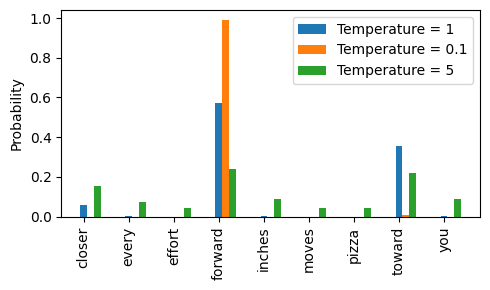

In [ ]:
# Plotting
x = torch.arange(len(vocab))
bar_width = 0.15

fig, ax = plt.subplots(figsize=(5, 3))
for i, T in enumerate(temperatures):
    rects = ax.bar(x + i * bar_width, scaled_probas[i], bar_width, label=f'Temperature = {T}')

ax.set_ylabel('Probability')
ax.set_xticks(x)
ax.set_xticklabels(vocab.keys(), rotation=90)
ax.legend()

plt.tight_layout()
plt.savefig("temperature-plot.pdf")
plt.show()

In [52]:
#Strategy 2: Top K Sampling
#example
next_token_logits = torch.tensor(
[4.51, 0.89, -1.90, 6.75, 1.63, -1.62, -1.89, 6.28, 1.79]
)

top_k=3
top_logits,top_pos=torch.topk(next_token_logits,top_k)
print("Top logits: ",top_logits)
print("Top positions: ",top_pos)
#gives top k probabilities values and its position(indices)

Top logits:  tensor([6.7500, 6.2800, 4.5100])
Top positions:  tensor([3, 7, 0])


In [53]:
#replace all logit values other than top k with negative inifinity

new_logits=torch.where(
    condition=next_token_logits<top_logits[-1],#checking the logits values less than last value of topk values
    input=torch.tensor(float("-inf")),
    other=next_token_logits
)

print(new_logits)

tensor([4.5100,   -inf,   -inf, 6.7500,   -inf,   -inf,   -inf, 6.2800,   -inf])


In [54]:
#applying softmax to the topk values
topk_probas=torch.softmax(new_logits,dim=0)
print(topk_probas)

tensor([0.0615, 0.0000, 0.0000, 0.5775, 0.0000, 0.0000, 0.0000, 0.3610, 0.0000])


In [55]:
#merge top-k sampling and temperature scaling

def generate(model,idx,max_new_tokens,context_size,temperature=0.0,top_k=None,eos_id=None):

    for _ in range(max_new_tokens):
        idx_cond=idx[:,-context_size:]
        with torch.no_grad():
            logits=model(idx_cond)
        logits=logits[:,-1,:]
        #getting the last vector of output

        if top_k is not None:

            top_logits,top_pos=torch.topk(logits,top_k)
            min_val=top_logits[:,-1]
            logits=torch.where(logits<min_val,torch.tensor(float("-inf")).to(logits.device),logits)

        if temperature>0.0:
            logits=logits/temperature

            probs=torch.softmax(logits,dim=-1)#(batch_size,context_length)

            idx_next=torch.multinomial(probs,num_samples=1)#(batch_size,1)

        else:
              idx_next=torch.argmax(logits,dim=-1,keepdim=True)

        if idx_next==eos_id:#stop generating if end of sequence token is encountered
            break
        
        idx=torch.cat((idx,idx_next),dim=1) #(batch_size,num_tokens+1)

    return idx
        

In [56]:
torch.manual_seed(123)

token_ids=generate(
    model=model,
    idx=text_to_token_ids("Every effort moves you ",tokenizer),
    max_new_tokens=15,
    context_size=GPT_CONFIG_124M["context_length"],
    top_k=25,
    temperature=1.4
)

print("Output text: ",token_ids_to_text(token_ids,tokenizer))


Output text:  Every effort moves you  Interactive trophyter Wasserman primarily Strauss opted Hir ExampleSensorulatory Hutу staggerrical


In [57]:
#saving model weights into a file

model=GPTModel(GPT_CONFIG_124M)
torch.save(model.state_dict(),"model.pth")
#.pth is a pytorch files

In [58]:
#loading saved weights into the model
model=GPTModel(GPT_CONFIG_124M)
model.load_state_dict(torch.load("model.pth"))
model.eval()

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(256, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_key): Linear(in_features=7

In [ ]:
#loading and saving weights for optimizer also with other weights because they use historical data to adjust learning rate

optimizer=torch.optim.AdamW(model.parameters(),lr=0.0004,weight_decay=0.1)

torch.save({
    "model_state_dict":model.state_dict(),
    "optimizer_state_dict":optimizer.state_dict()
},"model_and_optimizer.pth")

In [ ]:
checkpoint=torch.load("model_and_optimizer.pth")
model=GPTModel(GPT_CONFIG_124M)
model.load_state_dict(checkpoint["model_state_dict"])

optimizer=torch.optim.AdamW(model.parameters(),lr=0.0004,weight_decay=0.1)
optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
model.train()

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(256, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_key): Linear(in_features=7

In [59]:
%pip install  tensorflow>=2.15.0 tqdm>=4.66 

Note: you may need to restart the kernel to use updated packages.


In [61]:
import tensorflow as tf
import tqdm

print("Tensorflow version: ",tf.__version__)
print("tqdm version: ",tqdm.__version__)

Tensorflow version:  2.20.0
tqdm version:  4.67.1


In [62]:
#gpt_download3 is a file with functions for downloading and saving and loading gpt2 weights released by OpenAI
from gpt_download3 import download_and_load_gpt2


In [63]:
settings,param=download_and_load_gpt2(model_size="124M",models_dir="gpt2")

c:\Users\ffmou\AppData\Local\Programs\Python\Python313\Lib\site-packages\urllib3\connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openaipublic.blob.core.windows.net'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
models\124M\checkpoint: 100%|██████████| 77.0/77.0 [00:00<00:00, 46.9kiB/s]
c:\Users\ffmou\AppData\Local\Programs\Python\Python313\Lib\site-packages\urllib3\connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openaipublic.blob.core.windows.net'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
models\124M\encoder.json: 100%|██████████| 1.04M/1.04M [00:02<00:00, 410kiB/s] 
c:\Users\ffmou\AppData\Local\Programs\Python\Python313\Lib\site-packages\urllib3\connectionpool.py:1097: InsecureReque

In [64]:
print("Settings: ", settings)
print("Parameter Dictionary keys: ",param.keys())

Settings:  {'n_vocab': 50257, 'n_ctx': 1024, 'n_embd': 768, 'n_head': 12, 'n_layer': 12}
Parameter Dictionary keys:  dict_keys(['blocks', 'b', 'g', 'wpe', 'wte'])


In [66]:
print(param["wte"])
print("Token embedding weight tensor: ",param["wte"].shape)

[[-0.11010301 -0.03926672  0.03310751 ... -0.1363697   0.01506208
   0.04531523]
 [ 0.04034033 -0.04861503  0.04624869 ...  0.08605453  0.00253983
   0.04318958]
 [-0.12746179  0.04793796  0.18410145 ...  0.08991534 -0.12972379
  -0.08785918]
 ...
 [-0.04453601 -0.05483596  0.01225674 ...  0.10435229  0.09783269
  -0.06952604]
 [ 0.1860082   0.01665728  0.04611587 ... -0.09625227  0.07847701
  -0.02245961]
 [ 0.05135201 -0.02768905  0.0499369  ...  0.00704835  0.15519823
   0.12067825]]
Token embedding weight tensor:  (50257, 768)


In [67]:
# Define model configurations in a dictionary for compactness
model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}

# Copy the base configuration and update with specific model settings
model_name = "gpt2-small (124M)"  # Example model name
NEW_CONFIG = GPT_CONFIG_124M.copy()
NEW_CONFIG.update(model_configs[model_name])

In [69]:
NEW_CONFIG.update({"context_length":1024,"qkv_bias":True})
gpt=GPTModel(NEW_CONFIG)
gpt.eval();

In [ ]:
# a method for loading weights into a parameter (torch layer)
def assign(left,right):
    if left.shape != right.shape:
        raise ValueError(f"Shape mismatch. Left : {left.shape} Right:{right.shape}")
    return torch.nn.Parameter(torch.tensor(right))

In [80]:
#assigning all the pretrained weights into their specific layers

import numpy as np

def load_weights_into_gpt(gpt,params):

    gpt.pos_emb.weight=assign(gpt.pos_emb.weight,params['wpe'])
    gpt.tok_emb.weight=assign(gpt.tok_emb.weight,params['wte'])
    #weights for blocks inside transformer is stored in transpose
    #blocks contains weight,bias values for all parameters in all heads for a single transformer
    for b in range(len(params["blocks"])):#blocks key stores all the weights required for all the 12 heads in the transformer block
        #b- represents the head no
        q_w,k_w,v_w=np.split(params["blocks"][b]["attn"]["c_attn"]["w"],3,axis=-1)
        #splitting the weight matrix into query,key,values. openai concatenated these weights  after transposing it. that's why it is splitted along column into 3 parts
        gpt.trf_blocks[b].att.W_query.weight=assign(
            gpt.trf_blocks[b].att.W_query.weight,q_w.T
        ) 
        gpt.trf_blocks[b].att.W_key.weight=assign(
            gpt.trf_blocks[b].att.W_key.weight,k_w.T
        ) 
        gpt.trf_blocks[b].att.W_value.weight=assign(
            gpt.trf_blocks[b].att.W_value.weight,v_w.T
        ) 

        q_b,k_b,v_b=np.split(params["blocks"][b]["attn"]["c_attn"]["b"],3,axis=-1)
        #splitting the bias matrix into query,key,values. openai concatenated these biases. that's why it is splitted along column into 3 parts
        gpt.trf_blocks[b].att.W_query.bias=assign(
            gpt.trf_blocks[b].att.W_query.bias,q_b
        ) 
        gpt.trf_blocks[b].att.W_key.bias=assign(
            gpt.trf_blocks[b].att.W_key.bias,k_b
        ) 
        gpt.trf_blocks[b].att.W_value.bias=assign(
            gpt.trf_blocks[b].att.W_value.bias,v_b
        ) 

        #loading the weights and biases for the output projection layer in the transformer block(last block)
        gpt.trf_blocks[b].att.out_proj.weight=assign(
            gpt.trf_blocks[b].att.out_proj.weight,
            params["blocks"][b]["attn"]["c_proj"]["w"].T
        )
        gpt.trf_blocks[b].att.out_proj.bias=assign(
            gpt.trf_blocks[b].att.out_proj.bias,
            params["blocks"][b]["attn"]["c_proj"]["b"]
        )


        #loading the weights and biases for feedforward NN layers(fully-connected layer:768 x 4*768 ,projection layer: 4*768 x 768)
        #Fully-Connected layer
        gpt.trf_blocks[b].ff.layers[0].weight=assign(
            gpt.trf_blocks[b].ff.layers[0].weight,
            params["blocks"][b]["mlp"]["c_fc"]["w"].T
        )
        gpt.trf_blocks[b].ff.layers[0].bias=assign(
            gpt.trf_blocks[b].ff.layers[0].bias,
            params["blocks"][b]["mlp"]["c_fc"]["b"]
        )

        #projection layer
        gpt.trf_blocks[b].ff.layers[2].weight=assign(
            gpt.trf_blocks[b].ff.layers[2].weight,
            params["blocks"][b]["mlp"]["c_proj"]["w"].T
        )
        gpt.trf_blocks[b].ff.layers[2].bias=assign(
            gpt.trf_blocks[b].ff.layers[2].bias,
            params["blocks"][b]["mlp"]["c_proj"]["b"]
        )


        #loading weights for scale and shift parameters in normalization layers
        #Layer Normalization 1 
        gpt.trf_blocks[b].norm1.scale=assign(
            gpt.trf_blocks[b].norm1.scale,
            params["blocks"][b]["ln_1"]["g"]
        )
        gpt.trf_blocks[b].norm1.shift=assign(
            gpt.trf_blocks[b].norm1.shift,
            params["blocks"][b]["ln_1"]["b"]
        )
        #Layer Normalization 2
        gpt.trf_blocks[b].norm2.scale=assign(
            gpt.trf_blocks[b].norm2.scale,
            params["blocks"][b]["ln_2"]["g"]
        )
        gpt.trf_blocks[b].norm2.shift=assign(
            gpt.trf_blocks[b].norm2.shift,
            params["blocks"][b]["ln_2"]["b"]
        )

    #Final Normalization Layer in GPT
    gpt.final_norm.scale=assign(gpt.final_norm.scale,params["g"])
    gpt.final_norm.shift=assign(gpt.final_norm.shift,params["b"])

    #Linear output layer in GPT (use the token embeddings weight for this layer-weight tying)
    gpt.out_head.weight=assign(gpt.out_head.weight,params["wte"])


In [72]:
#loading pretrained weights into my gpt2 model
load_weights_into_gpt(gpt,param)
gpt.to(device);

In [86]:
#testing
torch.manual_seed(123)

token_ids=generate(
    model=gpt,
    idx=text_to_token_ids("Every effort moves you",tokenizer).to(device),
    max_new_tokens=25, 
    context_size=NEW_CONFIG["context_length"],
    top_k=50,
    temperature=1.5
)

print("Output text: ",token_ids_to_text(token_ids,tokenizer))


Output text:  Every effort moves you toward finding an ideal new way to practice something!

What makes us want to be on top of that?




In [87]:
#testing
torch.manual_seed(123)

token_ids=generate(
    model=gpt,
    idx=text_to_token_ids("How are you??",tokenizer).to(device),
    max_new_tokens=25, 
    context_size=NEW_CONFIG["context_length"],
    top_k=50,
    temperature=1.5
)

print("Output text: ",token_ids_to_text(token_ids,tokenizer))


Output text:  How are you?? Why did you get it then, but only after watching my wife cry? If he's on TV then that would be one
